# **VINICHO**

# PROCESAMIENTO DE DATOS

## Carga de datos

In [ ]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np

df1_path = 'TRAIN.txt'
df1 = pd.read_csv(df1_path, sep='|', encoding='utf-8')

df2_path = 'ETO.txt'
df2 = pd.read_csv(df2_path, sep='|', encoding='utf-8')

df3_path = 'METEO.txt'
df3 = pd.read_csv(df3_path, sep='|', encoding='utf-8')

## Exploracion de los datos

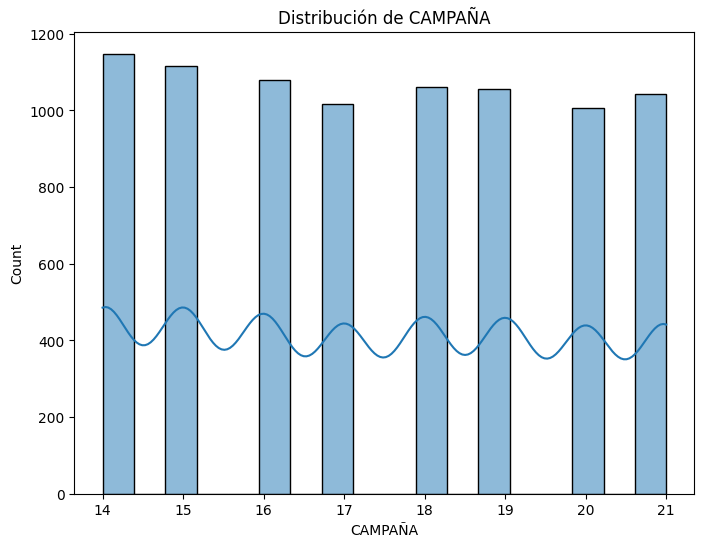

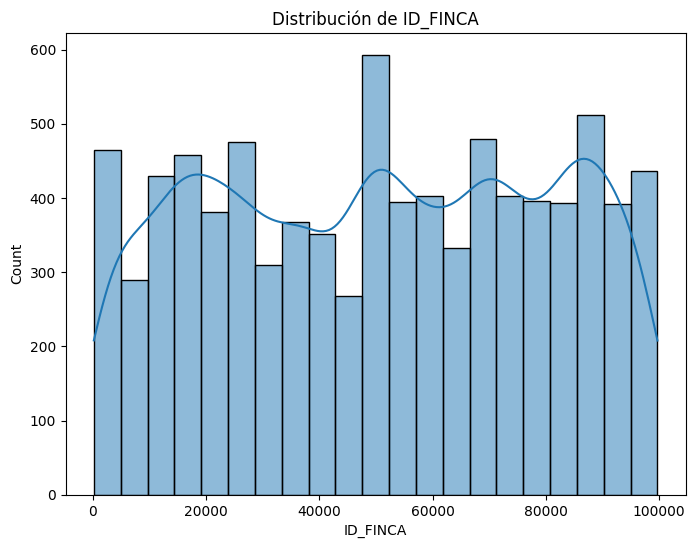

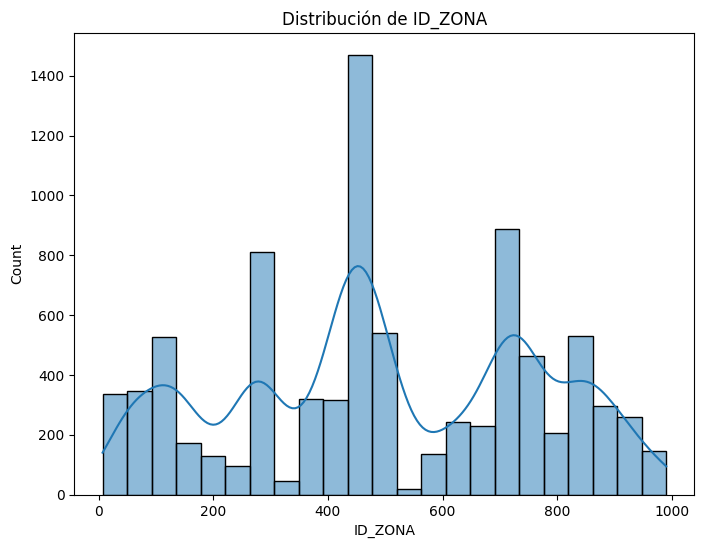

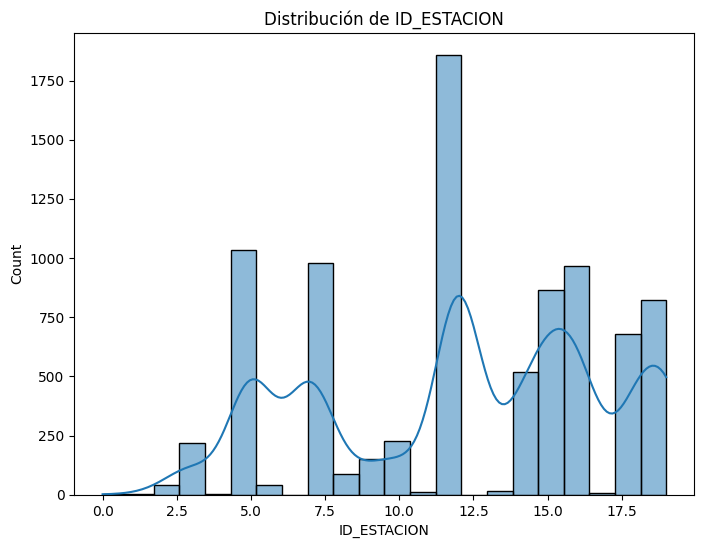

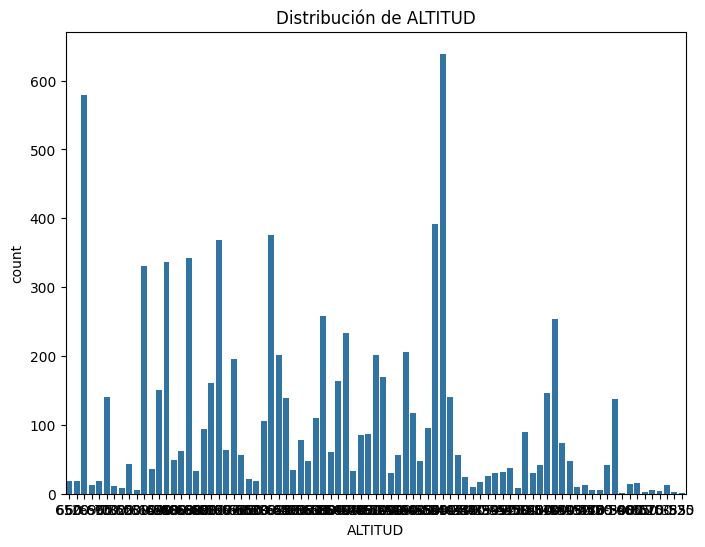

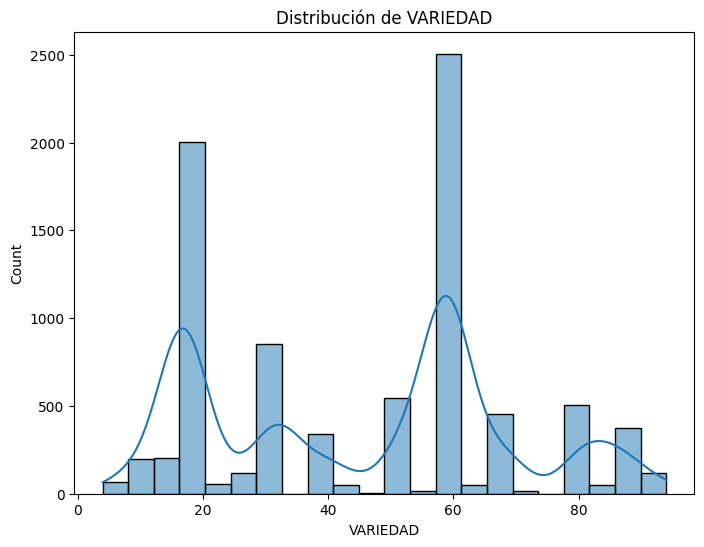

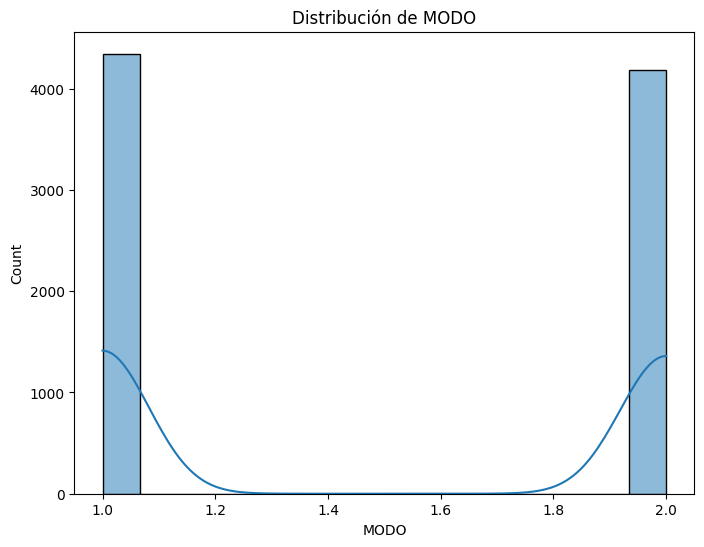

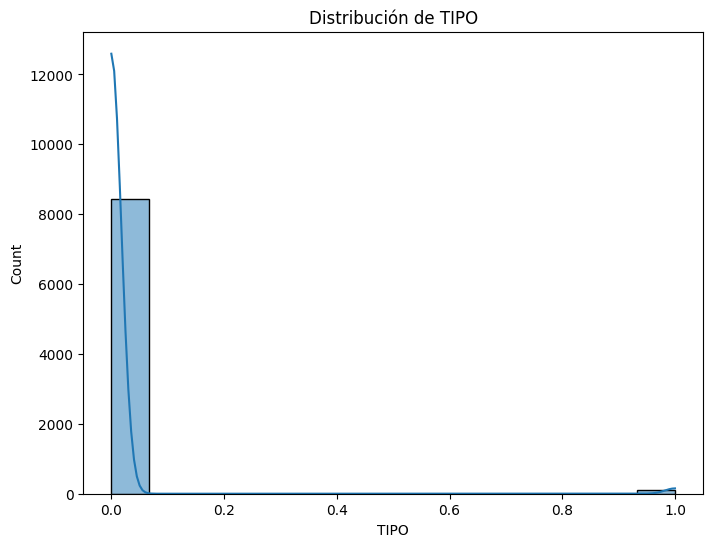

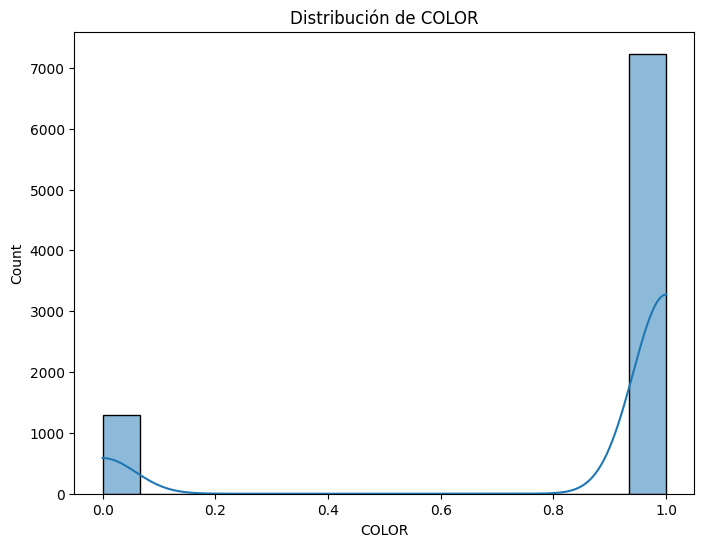

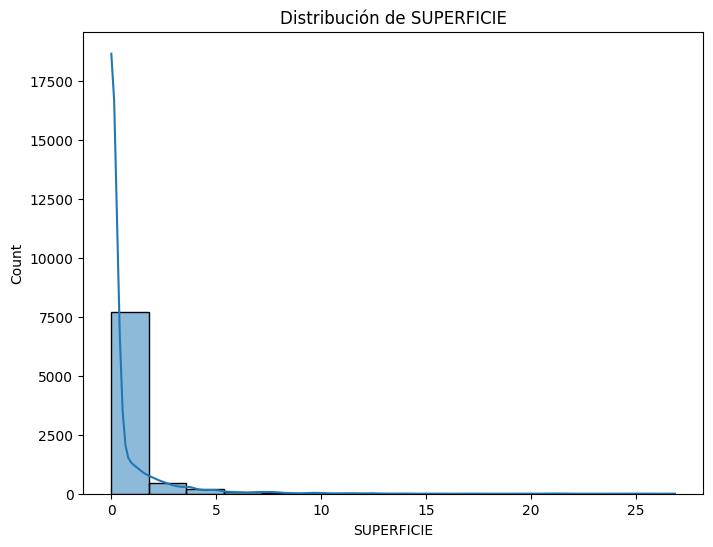

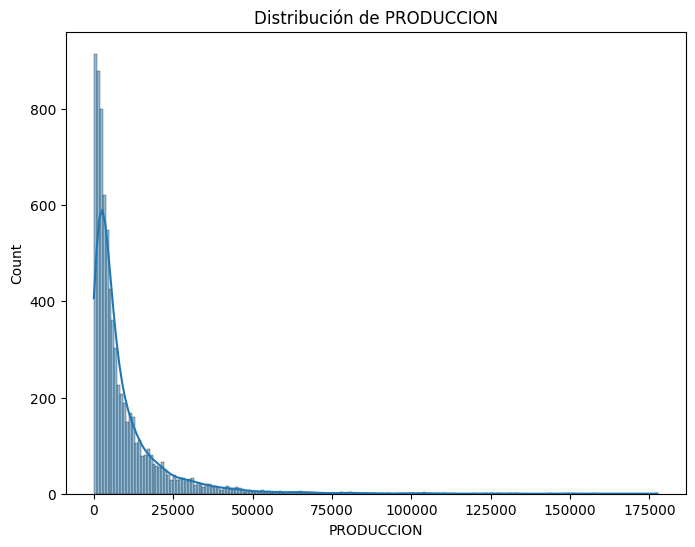

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in df1.columns:
  plt.figure(figsize=(8, 6))
  if df1[column].dtype == 'object':
    # Para variables categóricas, usar un gráfico de barras
    sns.countplot(x=column, data=df1)
  else:
    # Para variables numéricas, usar un histograma
    sns.histplot(df1[column], kde=True)
  plt.title(f'Distribución de {column}')
  plt.show()

## Imputación variable SUPERFICIE

In [ ]:
import pandas as pd
import numpy as np

# Reemplazar valores 0 en SUPERFICIE con NaN
df1['SUPERFICIE'] = df1['SUPERFICIE'].replace(0, pd.NA)

# Lista de columnas clave para coincidencias exactas
columnas_clave = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']

# Identificar registros con y sin superficie
sin_superficie = df1[df1['SUPERFICIE'].isna()]
con_superficie = df1[df1['SUPERFICIE'].notna()]

# PASO 1: Asignar por coincidencias exactas en todas las columnas clave
for idx, row in sin_superficie.iterrows():
    match = con_superficie
    for col in columnas_clave:
        match = match[match[col] == row[col]]  # Filtrar coincidencias exactas

    if not match.empty:
        df1.at[idx, 'SUPERFICIE'] = match['SUPERFICIE'].mean()  # Asigna la media

# Mostrar porcentaje de NaN después del primer intento
porcentaje_nan = df1['SUPERFICIE'].isna().mean() * 100
print(f"🔹 Después de coincidencias exactas: {porcentaje_nan:.2f}% NaN")

# Actualizar registros sin superficie después del primer intento
sin_superficie = df1[df1['SUPERFICIE'].isna()]

# PASO 2: Asignar por producción similar (+/-10%) y coincidencias en ALTITUD, VARIEDAD, MODO, TIPO, COLOR
columnas_filtradas = ['ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']

for idx, row in sin_superficie.iterrows():
    if pd.notna(row['PRODUCCION']):  # Asegurar que PRODUCCION no sea NaN
        prod_min = row['PRODUCCION'] * 0.9
        prod_max = row['PRODUCCION'] * 1.1

        match = con_superficie[
            (con_superficie['PRODUCCION'] >= prod_min) &
            (con_superficie['PRODUCCION'] <= prod_max)
        ]

        for col in columnas_filtradas:
            match = match[match[col] == row[col]]  # Filtrar coincidencias en los atributos

        if not match.empty:
            df1.at[idx, 'SUPERFICIE'] = match['SUPERFICIE'].mean()  # Asigna la media

# Mostrar porcentaje de NaN después del segundo intento
porcentaje_nan = df1['SUPERFICIE'].isna().mean() * 100
print(f"🔹 Después de producción similar y coincidencia en atributos: {porcentaje_nan:.2f}% NaN")

# PASO 3: Asignar por ID_FINCA
superficie_por_finca = df1.groupby('ID_FINCA')['SUPERFICIE'].first()
df1['SUPERFICIE'] = df1['ID_FINCA'].map(superficie_por_finca)

# Mostrar porcentaje de NaN después del tercer intento
porcentaje_nan = df1['SUPERFICIE'].isna().mean() * 100
print(f"🔹 Después de asignar por ID_FINCA: {porcentaje_nan:.2f}% NaN")

# PASO 4: Asignar por ID_ZONA con la mediana
df1['SUPERFICIE'] = pd.to_numeric(df1['SUPERFICIE'], errors='coerce')  # Convierte a numérico
df1['SUPERFICIE'] = df1.groupby('ID_ZONA')['SUPERFICIE'].transform(lambda x: x.fillna(x.median()))

# Mostrar porcentaje de NaN después del cuarto intento
porcentaje_nan = df1['SUPERFICIE'].isna().mean() * 100
print(f"🔹 Después de asignar por ID_ZONA (mediana): {porcentaje_nan:.2f}% NaN")

df1 = df1.dropna(subset=['SUPERFICIE'])

df1.to_csv('df1_clean.csv', index=False)
# Calcular el porcentaje de NaN final (debe ser 0%)
porcentaje_nan = df1['SUPERFICIE'].isna().mean() * 100
print(f"✅ El porcentaje final de valores NaN en SUPERFICIE es: {porcentaje_nan:.2f}%")


🔹 Después de coincidencias exactas: 22.77% NaN
🔹 Después de producción similar y coincidencia en atributos: 19.74% NaN
🔹 Después de asignar por ID_FINCA: 8.41% NaN
🔹 Después de asignar por ID_ZONA (mediana): 0.79% NaN
✅ El porcentaje final de valores NaN en SUPERFICIE es: 0.00%


/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke

## Transformación logaritimca

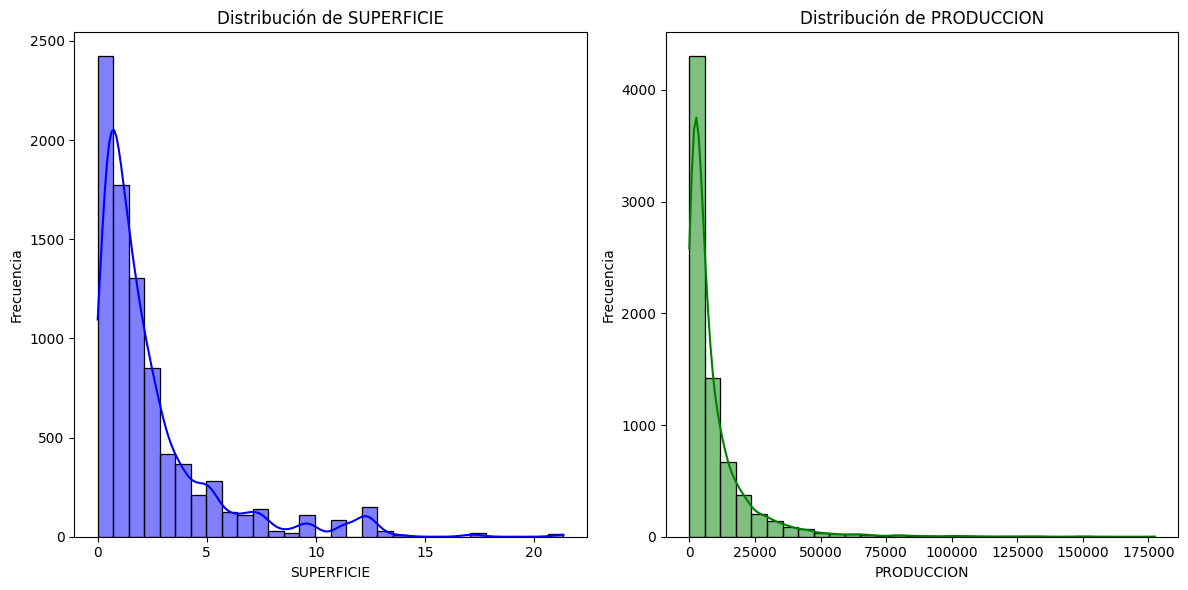

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Configuración del tamaño de las figuras
plt.figure(figsize=(12, 6))

# Gráfico de distribución para SUPERFICIE
plt.subplot(1, 2, 1)
sns.histplot(df1['SUPERFICIE'], kde=True, bins=30, color='blue')
plt.title('Distribución de SUPERFICIE')
plt.xlabel('SUPERFICIE')
plt.ylabel('Frecuencia')

# Gráfico de distribución para PRODUCCION
plt.subplot(1, 2, 2)
sns.histplot(df1['PRODUCCION'], kde=True, bins=30, color='green')
plt.title('Distribución de PRODUCCION')
plt.xlabel('PRODUCCION')
plt.ylabel('Frecuencia')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Aplicar transformación logarítmica a SUPERFICIE y PRODUCCION
df1["SUPERFICIE"] = np.log1p(df1["SUPERFICIE"])  # log(1 + x) para evitar log(0)
df1["PRODUCCION"] = np.log1p(df1["PRODUCCION"])  # log(1 + x)

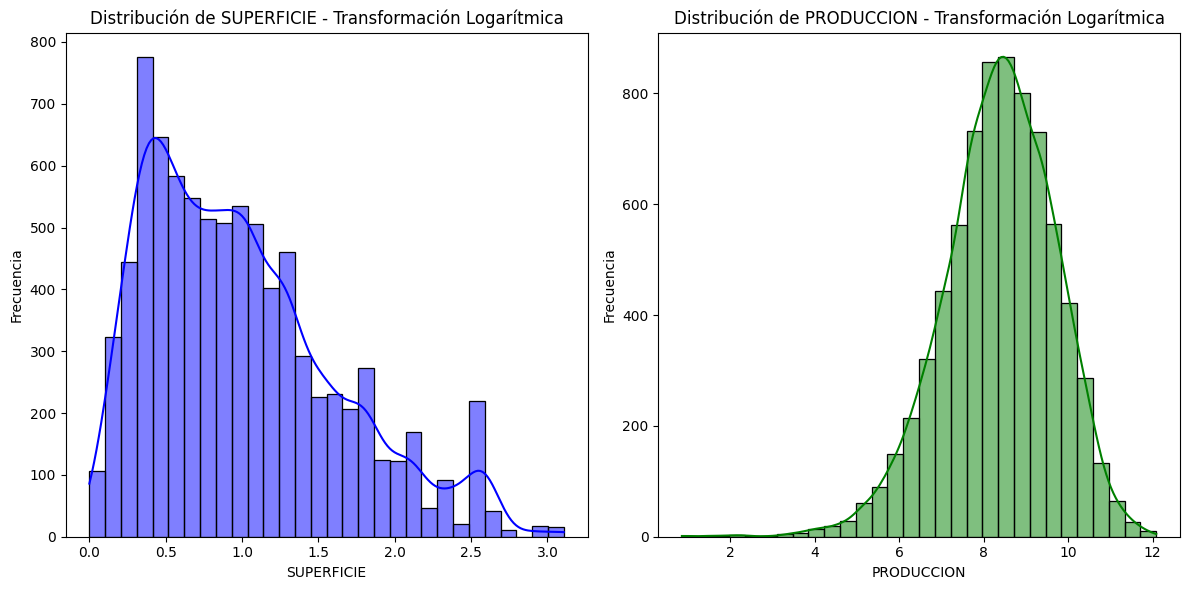

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Configuración del tamaño de las figuras
plt.figure(figsize=(12, 6))

# Gráfico de distribución para SUPERFICIE
plt.subplot(1, 2, 1)
sns.histplot(df1['SUPERFICIE'], kde=True, bins=30, color='blue')
plt.title('Distribución de SUPERFICIE - Transformación Logarítmica')
plt.xlabel('SUPERFICIE')
plt.ylabel('Frecuencia')

# Gráfico de distribución para PRODUCCION
plt.subplot(1, 2, 2)
sns.histplot(df1['PRODUCCION'], kde=True, bins=30, color='green')
plt.title('Distribución de PRODUCCION - Transformación Logarítmica')
plt.xlabel('PRODUCCION')
plt.ylabel('Frecuencia')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

      ID_FINCA  SUPERFICIE  PRODUCCION
3970       200    0.314811    6.721435
1819       200    0.314811    6.658145
5037       200    0.314811    6.410524
6109       200    0.314811    5.975559
671        200    0.314811    7.550135
7133       200    0.314811    6.303351
2915       200    0.314811    7.400743
8187       439    0.732368         NaN
1869       439    0.732368    8.073839
2964       439    0.732368    8.757060
724        439    0.732368    7.703549
1855       447    0.384854    8.084287
7158       447    0.384854    7.947869
2950       447    0.384854    7.415281
710        447    0.384854    7.509719
8176       447    0.384854         NaN
2949       447    0.384854    6.762854
4002       447    0.384854    7.198921
5652       523    0.499441    7.112184
6708       523    0.499441    6.855244
3565       523    0.499441    8.224967
4593       523    0.499441    7.950529
7720       523    0.499441         NaN
226        523    0.499441    7.736918
322        528    1.03953

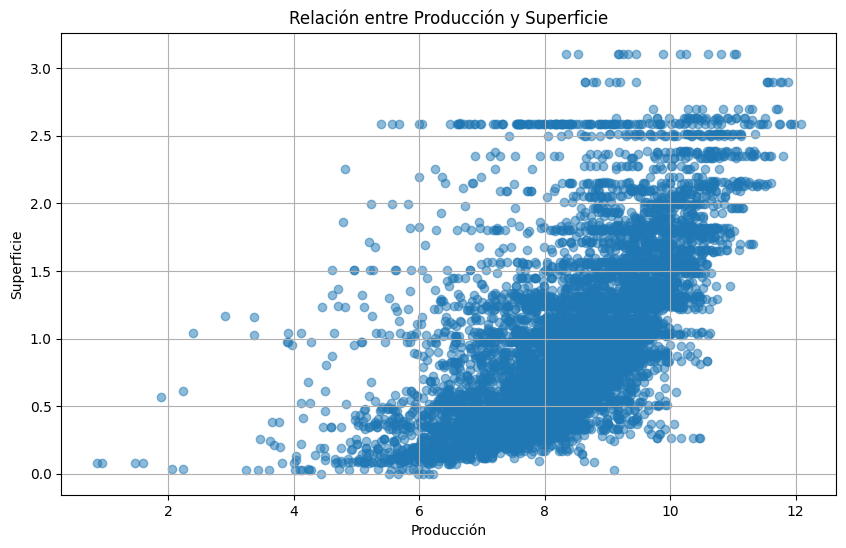

In [ ]:
import matplotlib.pyplot as plt

# Mostrar una tabla con los valores
tabla_muestra = df1[['ID_FINCA', 'SUPERFICIE', 'PRODUCCION']].sort_values(by='ID_FINCA').head(50)  # Muestra los primeros 50 registros
print(tabla_muestra)

# Visualizar gráficamente la relación entre PRODUCCION y SUPERFICIE
plt.figure(figsize=(10, 6))
plt.scatter(df1['PRODUCCION'], df1['SUPERFICIE'], alpha=0.5)
plt.xlabel('Producción')
plt.ylabel('Superficie')
plt.title('Relación entre Producción y Superficie')
plt.grid()
plt.show()

## Variable ALTITUD

Procesamos los datos para obtenerlos númericos

In [ ]:
import pandas as pd
import numpy as np


def calcular_altitud_media(valor):
  """Calcula la media del intervalo si el valor tiene el formato "600-630",
  de lo contrario, devuelve el valor original.
  """
  if '-' in str(valor):
    minimo, maximo = map(int, valor.split('-'))
    return (minimo + maximo) / 2
  else:
    return float(valor)

# Aplicar la función a la columna "altitud"
df1['ALTITUD'] = df1['ALTITUD'].apply(calcular_altitud_media)

Tratamos outliers

In [ ]:
# Calculate quartiles
Q1 = df1['ALTITUD'].quantile(0.25)
Q3 = df1['ALTITUD'].quantile(0.75)
IQR = Q3 - Q1

# Calculate upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Find outliers
outliers = df1[(df1['ALTITUD'] > upper_bound) | (df1['ALTITUD'] < lower_bound)]

# Print results
print(f"Número de outliers: {len(outliers)}")
print("\nOutliers:")
print(outliers)

Número de outliers: 0

Outliers:
Empty DataFrame
Columns: [CAMPAÑA, ID_FINCA, ID_ZONA, ID_ESTACION, ALTITUD, VARIEDAD, MODO, TIPO, COLOR, SUPERFICIE, PRODUCCION]
Index: []


Exploramos los datos

In [ ]:
media_altitud = df1['ALTITUD'].mean()

mediana_altitud = df1['ALTITUD'].median()

print(f"Media de ALTITUD: {media_altitud}")
print(f"Mediana de ALTITUD: {mediana_altitud}")

Media de ALTITUD: 577.3191842542092
Mediana de ALTITUD: 610.0


Imputamos los missings

In [ ]:
num_missing_before = df1['ALTITUD'].isnull().sum()

df1['ALTITUD'] = df1['ALTITUD'].fillna(media_altitud)

num_missing_after = df1['ALTITUD'].isnull().sum()

num_imputed = num_missing_before - num_missing_after

print(f"Número de registros imputados en ALTITUD: {num_imputed}")

Número de registros imputados en ALTITUD: 25


## Valores faltantes

In [ ]:
missing_values_filas = df2.isnull().sum(axis=1)
print('\nValores faltantes por fila:')
print(missing_values_filas.head())

missing_percentage_filas = df2.isnull().mean(axis=1) * 100
print('\nPorcentaje de valores faltantes por fila:')
print(missing_percentage_filas.head())


Valores faltantes por fila:
0    111
1     75
2     84
3     72
4     81
dtype: int64

Porcentaje de valores faltantes por fila:
0    40.363636
1    27.272727
2    30.545455
3    26.181818
4    29.454545
dtype: float64


In [ ]:
original_size = df1.shape[1]

# Calcular valores faltantes y porcentaje por columna
missing_values_columnas = df1.isnull().sum()
missing_percentage_columnas = (missing_values_columnas / len(df1)) * 100

# Crear un DataFrame con los valores para columnas
missing_data_columnas = pd.DataFrame({
    'Valores Faltantes': missing_values_columnas,
    'Porcentaje Faltante (%)': missing_percentage_columnas
})

# Filtrar y eliminar las columnas con más del 30% de valores faltantes
df1 = df1.loc[:, missing_percentage_columnas <= 30]  # Usar loc para seleccionar columnas

# Mostrar el número de columnas eliminadas
num_columnas_eliminadas = original_size - df1.shape[1]  # Cambiar a shape[1]
print(f"\nSe han eliminado {num_columnas_eliminadas} columnas con más del 30% de valores faltantes.")

# Mostrar el DataFrame limpio
print(df1.head())


Se han eliminado 0 columnas con más del 30% de valores faltantes.
    CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION  ALTITUD  VARIEDAD  MODO  TIPO  \
12       14      5696      919           14    655.0        59     1     0   
13       14     98814      919           14    655.0        32     2     0   
14       14     98814      919           14    655.0        40     2     0   
15       14      4024      919           14    655.0        32     2     0   
16       14      4024      919           14    655.0        87     2     0   

    COLOR  SUPERFICIE  PRODUCCION  
12      1    2.154085    9.994635  
13      1    2.099942   10.357663  
14      1    2.099942    9.740439  
15      1    2.511224   10.913176  
16      0    2.511224    9.506065  


In [ ]:
original_size = df1.shape[0]


#Crear un DataFrame con ambos valores
missing_data_filas = pd.DataFrame({
    'Valores Faltantes': missing_values_filas,
    'Porcentaje Faltante (%)': missing_percentage_filas
})

#Filtrar y eliminar las filas con más del 50% de valores faltantes
df1 = df1[missing_percentage_filas <= 50]

#Mostrar el número de filas eliminadas
num_filas_eliminadas = original_size - df1.shape[0]
print(f"\nSe han eliminado {num_filas_eliminadas} filas con más del 50% de valores faltantes.")

#Mostrar el DataFrame limpio
print(df1.head())


Se han eliminado 0 filas con más del 50% de valores faltantes.
    CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION  ALTITUD  VARIEDAD  MODO  TIPO  \
12       14      5696      919           14    655.0        59     1     0   
13       14     98814      919           14    655.0        32     2     0   
14       14     98814      919           14    655.0        40     2     0   
15       14      4024      919           14    655.0        32     2     0   
16       14      4024      919           14    655.0        87     2     0   

    COLOR  SUPERFICIE  PRODUCCION  
12      1    2.154085    9.994635  
13      1    2.099942   10.357663  
14      1    2.099942    9.740439  
15      1    2.511224   10.913176  
16      0    2.511224    9.506065  


/var/folders/yh/8dr11nzd5nx2wzw16251t8b40000gn/T/ipykernel_11103/1197806149.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[missing_percentage_filas <= 50]


In [ ]:
zeros_per_column = (df1 == 0).sum()

# Print the results
print(zeros_per_column)

CAMPAÑA           0
ID_FINCA          0
ID_ZONA           0
ID_ESTACION       1
ALTITUD           0
VARIEDAD          0
MODO              0
TIPO           8365
COLOR          1291
SUPERFICIE        0
PRODUCCION        0
dtype: int64


## Extraemos los datos de la variable a predecir 2021

In [ ]:
df2.head()

date  DewpointLocalAfternoonAvg  DewpointLocalAfternoonMax  \
0  20150629                      285.9                      285.9   
1  20150630                      283.0                      283.6   
2  20150701                      286.1                      286.5   
3  20150702                      288.9                      289.4   
4  20150703                      289.1                      290.4   

   DewpointLocalAfternoonMin  DewpointLocalDayAvg  DewpointLocalDayMax  \
0                      285.9                286.0                287.0   
1                      282.5                284.3                286.5   
2                      285.5                285.8                288.0   
3                      287.9                288.3                291.8   
4                      288.5                290.5                293.0   

   DewpointLocalDayMin  DewpointLocalDaytimeAvg  DewpointLocalDaytimeMax  \
0                285.4                    285.9                    285.9   
1                282.5                    283.2                    283.9   
2                283.8                    285.4                    286.5   
3                286.1                    287.7                    289.4   
4                287.8                    290.6                    293.0   

   DewpointLocalDaytimeMin  ...  WindSpeedLocalMorningAvg  \
0                    285.9  ...                       NaN   
1                    282.5  ...                       2.2   
2                    283.8  ...                       2.7   
3                    286.1  ...                       1.7   
4                    288.5  ...                       3.5   

   WindSpeedLocalMorningMax  WindSpeedLocalMorningMin  \
0                       NaN                       NaN   
1                       3.8                       1.4   
2                       4.3                       1.2   
3                       2.3                       1.2   
4                       5.0                       2.3   

   WindSpeedLocalNighttimeAvg  WindSpeedLocalNighttimeMax  \
0                         2.6                         5.0   
1                         2.7                         5.2   
2                         3.0                         5.7   
3                         3.6                         5.4   
4                         3.1                         6.0   

   WindSpeedLocalNighttimeMin  WindSpeedLocalOvernightAvg  \
0                         1.1                         1.7   
1                         1.4                         1.5   
2                         1.4                         1.9   
3                         2.4                         2.7   
4                         1.5                         1.9   

   WindSpeedLocalOvernightMax  WindSpeedLocalOvernightMin  ID_ESTACION  
0                         2.1                         1.1           13  
1                         1.9                         1.4           13  
2                         2.8                         1.4           13  
3                         3.4                         2.4           13  
4                         2.2                         1.5           13  

[5 rows x 275 columns]

In [ ]:
df1_2021 = df1[df1['CAMPAÑA'] == 21]
# Formato de fecha adecuado
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d')
df2_2021 = df2[df2['date'].dt.year == 2021]

In [ ]:
# Crear df1_clean con las filas diferentes a 21 en CAMAÑA
df1_clean = df1[df1['CAMPAÑA'] == 21]

# Eliminar las filas con CAMAÑA igual a 21 de df1
df1 = df1[df1['CAMPAÑA'] != 21]


print(f"df1 tiene {df1.shape[0]} filas.")
print(f"df1_clean tiene {df1_clean.shape[0]} filas.")

df1 tiene 7415 filas.
df1_clean tiene 1044 filas.


## Unimos ETO y TRAIN

In [ ]:
import pandas as pd
import numpy as np

# Formato de fecha adecuado
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d')

def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 'Winter'
    elif mes in [3, 4, 5]:
        return 'Spring'
    elif mes in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Asignar estaciones
df2['season'] = df2['date'].apply(obtener_estacion)

# Variables de interés
vars_df2 = ['DewpointLocalDayAvg', 'FeelsLikeLocalDayAvg', 'PrecipAmountLocalDayAvg', 'RelativeHumidityLocalDayAvg', 'SnowAmountLocalDayAvg', 'TemperatureLocalDayAvg', 'UVIndexLocalDayAvg', 'VisibilityLocalDayAvg', 'WindSpeedLocalDayAvg']

# Agrupar y calcular medias estacionales para df2
df2_seasonal = df2.groupby(['ID_ESTACION', 'season'])[vars_df2].mean().reset_index()
df2_seasonal = df2_seasonal.pivot(index='ID_ESTACION', columns='season').reset_index()
df2_seasonal.columns = ['ID_ESTACION'] + [f'{col[0]}_{col[1]}' for col in df2_seasonal.columns[1:]]

df1['ID_ESTACION'] = pd.to_numeric(df1['ID_ESTACION'], errors='coerce')
df1['ID_ESTACION'] = df1['ID_ESTACION'].fillna(0).astype(int)
df1['ID_ESTACION'] = df1['ID_ESTACION'].astype(int)
df2_seasonal['ID_ESTACION'] = df2_seasonal['ID_ESTACION'].astype(int)

# Unir con el dataset principal
df_final = df1.merge(df2_seasonal, on='ID_ESTACION', how='left')
# df_final = df_final.merge(df3_seasonal, on='ID_ESTACION', how='left')

# Resultado
print(df_final.head())
df_final.to_csv('df_final.csv', index=False)


   CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION  ALTITUD  VARIEDAD  MODO  TIPO  \
0       14      5696      919           14    655.0        59     1     0   
1       14     98814      919           14    655.0        32     2     0   
2       14     98814      919           14    655.0        40     2     0   
3       14      4024      919           14    655.0        32     2     0   
4       14      4024      919           14    655.0        87     2     0   

   COLOR  SUPERFICIE  ...  UVIndexLocalDayAvg_Summer  \
0      1    2.154085  ...                   2.352708   
1      1    2.099942  ...                   2.352708   
2      1    2.099942  ...                   2.352708   
3      1    2.511224  ...                   2.352708   
4      0    2.511224  ...                   2.352708   

   UVIndexLocalDayAvg_Winter  VisibilityLocalDayAvg_Autumn  \
0                   0.459225                  12841.188645   
1                   0.459225                  12841.188645   
2             

Unimos df1 y df2 de 2021, que utilizaremos mas adelante para enviar el fichero con las predicciones

In [ ]:
import pandas as pd
import numpy as np

# Formato de fecha adecuado
df2_2021['date'] = pd.to_datetime(df2_2021['date'], format='%Y%m%d')

def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 'Winter'
    elif mes in [3, 4, 5]:
        return 'Spring'
    elif mes in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Asignar estaciones
df2_2021['season'] = df2_2021['date'].apply(obtener_estacion)

# Variables de interés
vars_df2 = ['DewpointLocalDayAvg', 'FeelsLikeLocalDayAvg', 'PrecipAmountLocalDayAvg', 'RelativeHumidityLocalDayAvg', 'SnowAmountLocalDayAvg', 'TemperatureLocalDayAvg', 'UVIndexLocalDayAvg', 'VisibilityLocalDayAvg', 'WindSpeedLocalDayAvg']

# Agrupar y calcular medias estacionales para df2_2021
df2_seasonal = df2_2021.groupby(['ID_ESTACION', 'season'])[vars_df2].mean().reset_index()
df2_seasonal = df2_seasonal.pivot(index='ID_ESTACION', columns='season').reset_index()
df2_seasonal.columns = ['ID_ESTACION'] + [f'{col[0]}_{col[1]}' for col in df2_seasonal.columns[1:]]

df1_2021['ID_ESTACION'] = pd.to_numeric(df1_2021['ID_ESTACION'], errors='coerce')
df1_2021['ID_ESTACION'] = df1_2021['ID_ESTACION'].fillna(0).astype(int)
df1_2021['ID_ESTACION'] = df1_2021['ID_ESTACION'].astype(int)
df2_seasonal['ID_ESTACION'] = df2_seasonal['ID_ESTACION'].astype(int)

# Unir con el dataset principal
df_final_2021 = df1_2021.merge(df2_seasonal, on='ID_ESTACION', how='left')
# df_final = df_final.merge(df3_seasonal, on='ID_ESTACION', how='left')

# Resultado
print(df_final_2021.head())
df_final_2021.to_csv('df_final_2021.csv', index=False)

   CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION     ALTITUD  VARIEDAD  MODO  TIPO  \
0       21     48626      302           13  600.000000        32     2     0   
1       21     47921      302           13  600.000000        32     2     0   
2       21     28875      548           14  577.319184        17     2     0   
3       21      5696      919           14  655.000000        59     1     0   
4       21     48093      919           14  655.000000        59     2     0   

   COLOR  SUPERFICIE  ...  TemperatureLocalDayAvg_Winter  \
0      1    1.558208  ...                     281.530508   
1      1    2.125072  ...                     281.530508   
2      1    1.297900  ...                     280.322034   
3      1    2.154085  ...                     280.322034   
4      1    1.241471  ...                     280.322034   

   UVIndexLocalDayAvg_Spring  UVIndexLocalDayAvg_Summer  \
0                   1.573913                   2.413333   
1                   1.573913            

/var/folders/yh/8dr11nzd5nx2wzw16251t8b40000gn/T/ipykernel_11103/2506339982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_2021['date'] = pd.to_datetime(df2_2021['date'], format='%Y%m%d')
/var/folders/yh/8dr11nzd5nx2wzw16251t8b40000gn/T/ipykernel_11103/2506339982.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_2021['season'] = df2_2021['date'].apply(obtener_estacion)


In [ ]:
print(df_final_2021.columns.tolist())
# Comprobar si la columna UVIndexLocalDayAvg_Autumn está en df_final_2021
if 'UVIndexLocalDayAvg_Autumn' in df_final_2021.columns:
    print("La columna UVIndexLocalDayAvg_Autumn está en df_final_2021.")
else:
    print("La columna UVIndexLocalDayAvg_Autumn NO está en df_final_2021.")

['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'DewpointLocalDayAvg_Spring', 'DewpointLocalDayAvg_Summer', 'DewpointLocalDayAvg_Winter', 'FeelsLikeLocalDayAvg_Spring', 'FeelsLikeLocalDayAvg_Summer', 'FeelsLikeLocalDayAvg_Winter', 'PrecipAmountLocalDayAvg_Spring', 'PrecipAmountLocalDayAvg_Summer', 'PrecipAmountLocalDayAvg_Winter', 'RelativeHumidityLocalDayAvg_Spring', 'RelativeHumidityLocalDayAvg_Summer', 'RelativeHumidityLocalDayAvg_Winter', 'SnowAmountLocalDayAvg_Winter', 'TemperatureLocalDayAvg_Spring', 'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter', 'UVIndexLocalDayAvg_Spring', 'UVIndexLocalDayAvg_Summer', 'UVIndexLocalDayAvg_Winter', 'VisibilityLocalDayAvg_Spring', 'VisibilityLocalDayAvg_Summer', 'VisibilityLocalDayAvg_Winter', 'WindSpeedLocalDayAvg_Spring', 'WindSpeedLocalDayAvg_Summer', 'WindSpeedLocalDayAvg_Winter']
La columna UVIndexLocalDayAvg_Autumn NO está en df_final_2021.


## Limpieza

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Columnas de identificación a preservar
columnas_id = ['ID_ESTACION', 'ID_FINCA', 'ID_ZONA', 'CAMPAÑA', 'TIPO', 'VARIEDAD', 'COLOR', 'MODO']

# Umbral para considerar columnas con muchos ceros/nulos
umbral_faltantes = 0.4

# Columnas a evaluar (excluyendo IDs)
columnas_a_evaluar = [col for col in df_final.columns if col not in columnas_id]

# Identificar columnas con muchos ceros (solo numéricas)
cols_muchos_ceros = [col for col in columnas_a_evaluar
                     if df_final[col].dtype in [np.float64, np.int64] and
                     (df_final[col] == 0).sum() / len(df_final) > umbral_faltantes]

# Identificar columnas con muchos nulos
cols_muchos_nulos = [col for col in columnas_a_evaluar
                     if df_final[col].isnull().sum() / len(df_final) > umbral_faltantes]

# Eliminar columnas con demasiados ceros o nulos
cols_a_eliminar = list(set(cols_muchos_ceros + cols_muchos_nulos))
df_final.drop(columns=cols_a_eliminar, inplace=True)
print(f"Columnas eliminadas por muchos ceros/nulos: {cols_a_eliminar}")

# Volver a identificar columnas a evaluar (excluyendo IDs)
columnas_a_evaluar = [col for col in df_final.columns if col not in columnas_id]

# Separar por tipo
num_cols = [col for col in columnas_a_evaluar if df_final[col].dtype in [np.float64, np.int64]]
cat_cols = [col for col in columnas_a_evaluar if df_final[col].dtype == 'object']

# Imputación categórica: moda por grupo de 'ID_ZONA' si está disponible
if 'ID_ZONA' in df_final.columns:
    for col in cat_cols:
        if df_final[col].isnull().sum() > 0:
            df_final[col] = df_final.groupby('ID_ZONA')[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else 'Desconocido'
            )
else:
    for col in cat_cols:
        if df_final[col].isnull().sum() > 0:
            df_final[col].fillna(df_final[col].mode()[0], inplace=True)

# Imputación numérica avanzada con KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
df_final[num_cols] = imputer_knn.fit_transform(df_final[num_cols])

# Eliminar duplicados
df_final.drop_duplicates(inplace=True)

# Confirmar limpieza
print("Datos después de la limpieza:")
print(df_final.info())

# Guardar el dataset limpio
df_final.to_csv('df_final_limpio.csv', index=False)

Columnas eliminadas por muchos ceros/nulos: ['SnowAmountLocalDayAvg_Autumn', 'SnowAmountLocalDayAvg_Spring', 'SnowAmountLocalDayAvg_Summer']
Datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7415 entries, 0 to 7414
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CAMPAÑA                             7415 non-null   int64  
 1   ID_FINCA                            7415 non-null   int64  
 2   ID_ZONA                             7415 non-null   int64  
 3   ID_ESTACION                         7415 non-null   int64  
 4   ALTITUD                             7415 non-null   float64
 5   VARIEDAD                            7415 non-null   int64  
 6   MODO                                7415 non-null   int64  
 7   TIPO                                7415 non-null   int64  
 8   COLOR                               7415 non-null   int64  
 9   SU

Hacemos lo mismo para los datos de 2021 (que utilizaremos al final para enviar el fichero de la predicción)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Columnas de identificación a preservar
columnas_id = ['ID_ESTACION', 'ID_FINCA', 'ID_ZONA', 'CAMPAÑA', 'TIPO', 'VARIEDAD', 'COLOR', 'MODO']

# Umbral para considerar columnas con muchos ceros/nulos
umbral_faltantes = 0.4

# Columnas a evaluar (excluyendo IDs)
columnas_a_evaluar = [col for col in df_final_2021.columns if col not in columnas_id]

# Identificar columnas con muchos ceros (solo numéricas)
cols_muchos_ceros = [col for col in columnas_a_evaluar
                     if df_final_2021[col].dtype in [np.float64, np.int64] and
                     (df_final_2021[col] == 0).sum() / len(df_final_2021) > umbral_faltantes]

# Identificar columnas con muchos nulos
cols_muchos_nulos = [col for col in columnas_a_evaluar
                     if df_final_2021[col].isnull().sum() / len(df_final_2021) > umbral_faltantes]

# Eliminar columnas con demasiados ceros o nulos
cols_a_eliminar = list(set(cols_muchos_ceros + cols_muchos_nulos))
df_final_2021.drop(columns=cols_a_eliminar, inplace=True)
print(f"Columnas eliminadas por muchos ceros/nulos: {cols_a_eliminar}")

# Volver a identificar columnas a evaluar (excluyendo IDs)
columnas_a_evaluar = [col for col in df_final_2021.columns if col not in columnas_id]

# Separar por tipo
num_cols = [col for col in columnas_a_evaluar if df_final_2021[col].dtype in [np.float64, np.int64]]
cat_cols = [col for col in columnas_a_evaluar if df_final_2021[col].dtype == 'object']

# Imputación categórica: moda por grupo de 'ID_ZONA' si está disponible
if 'ID_ZONA' in df_final_2021.columns:
    for col in cat_cols:
        if df_final_2021[col].isnull().sum() > 0:
            df_final_2021[col] = df_final_2021.groupby('ID_ZONA')[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else 'Desconocido'
            )
else:
    for col in cat_cols:
        if df_final_2021[col].isnull().sum() > 0:
            df_final_2021[col].fillna(df_final_2021[col].mode()[0], inplace=True)

# Imputación numérica avanzada con KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
df_final_2021[num_cols] = imputer_knn.fit_transform(df_final_2021[num_cols])

# Eliminar duplicados
df_final_2021.drop_duplicates(inplace=True)

# Confirmar limpieza
print("Datos después de la limpieza:")
print(df_final_2021.info())

# Guardar el dataset limpio
df_final_2021.to_csv('df_final_2021_limpio.csv', index=False)

Columnas eliminadas por muchos ceros/nulos: ['PRODUCCION', 'SnowAmountLocalDayAvg_Spring', 'SnowAmountLocalDayAvg_Summer']
Datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CAMPAÑA                             1044 non-null   int64  
 1   ID_FINCA                            1044 non-null   int64  
 2   ID_ZONA                             1044 non-null   int64  
 3   ID_ESTACION                         1044 non-null   int64  
 4   ALTITUD                             1044 non-null   float64
 5   VARIEDAD                            1044 non-null   int64  
 6   MODO                                1044 non-null   int64  
 7   TIPO                                1044 non-null   int64  
 8   COLOR                               1044 non-null   int64  
 9   SUPERFICIE          

In [ ]:
# Si no tienes instalada la librería:
!pip install category_encoders

In [ ]:
# !pip install numpy

In [ ]:
!pip install catboost

In [ ]:
!pip install numpy==1.24.4

# MODELOS

## ENSEMBLE 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform

# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X[df['CAMPAÑA'] != 19]
y_train = y[df['CAMPAÑA'] != 19]

X_test = X[df['CAMPAÑA'] == 19]
y_test = y[df['CAMPAÑA'] == 19]

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(random_state=42),
    # 'SVR': SVR(),
    # 'MLP': MLPRegressor(random_state=42),
    # 'KNeighbors': KNeighborsRegressor(),
    # 'Ridge': Ridge(),
    # 'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    'XGBoost': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.5, 0.5),
        'model__gamma': uniform(0, 5),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'RandomForest': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
    },
    'LightGBM': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__num_leaves': randint(20, 100),
        'model__feature_fraction': uniform(0.5, 0.5),
        'model__bagging_fraction': uniform(0.5, 0.5),
        'model__min_child_samples': randint(10, 100),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'CatBoost': {
        'model__iterations': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__depth': randint(3, 15),
        'model__l2_leaf_reg': uniform(1, 10),
        'model__random_strength': uniform(0.5, 2),
        'model__bagging_temperature': uniform(0, 1),
        'model__leaf_estimation_iterations': randint(1, 10)
    },
    'GradientBoosting': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
        'model__subsample': uniform(0.5, 0.5)
    },
    'ExtraTrees': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
     }#,
    # 'SVR': {
    #     'model__C': uniform(0.1, 10),
    #     'model__epsilon': uniform(0.01, 1),
    #     'model__kernel': ['rbf', 'linear', 'poly']
    # },
    # 'MLP': {
    #     'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    #     'model__activation': ['relu', 'tanh'],
    #     'model__alpha': uniform(0.0001, 0.01),
    #     'model__learning_rate_init': uniform(0.001, 0.1)
    # },
    # 'KNeighbors': {
    #     'model__n_neighbors': randint(3, 30),
    #     'model__weights': ['uniform', 'distance'],
    #     'model__p': [1, 2]
    # },
    # 'Ridge': {
    #     'model__alpha': uniform(0.1, 10)
    # },
    # 'BayesianRidge': {
    #     'model__max_iter': randint(100, 500)
    # }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 6361, number of used features: 21
[LightGBM] [Info] Start training from score 8.354227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 21
[LightGBM] [Info] Start training from score 8.351349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6293899908000085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293899908000085
[LightGBM] [Warning] bagging_fraction is set=0.954660201039391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.954660201039391


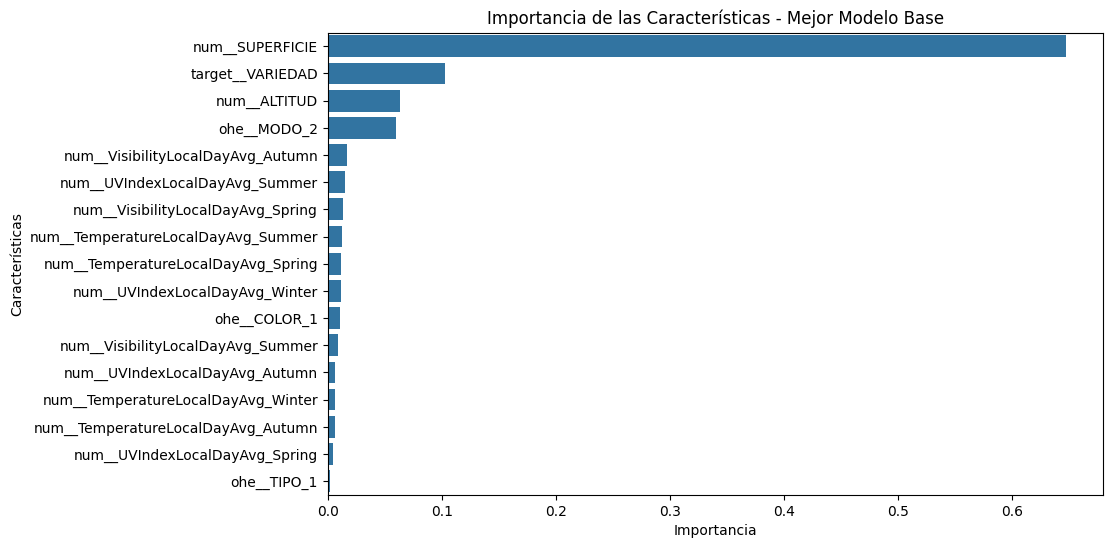

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor del ensemble 1)

estimadores_stacking = [(nombre, modelo) for nombre, modelo in modelos_base.items()]

ensemble1 = StackingRegressor(
    estimators=estimadores_stacking,
    final_estimator=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1),
    cv=kf,
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble1.fit(X_train, y_train)
y_pred = ensemble1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]

# Check if the model has feature_importances_ attribute
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

## Ensemble 2

In [ ]:
# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X[df['CAMPAÑA'] != 19]
y_train = y[df['CAMPAÑA'] != 19]

X_test = X[df['CAMPAÑA'] == 19]
y_test = y[df['CAMPAÑA'] == 19]

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    # 'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    # 'RandomForest': RandomForestRegressor(random_state=42),
    # 'LightGBM': LGBMRegressor(random_state=42),
    # 'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(random_state=42),
    # 'ExtraTrees': ExtraTreesRegressor(random_state=42),
    # 'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    # 'XGBoost': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__subsample': uniform(0.5, 0.5),
    #     'model__colsample_bytree': uniform(0.5, 0.5),
    #     'model__gamma': uniform(0, 5),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'RandomForest': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    # },
    # 'LightGBM': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__num_leaves': randint(20, 100),
    #     'model__feature_fraction': uniform(0.5, 0.5),
    #     'model__bagging_fraction': uniform(0.5, 0.5),
    #     'model__min_child_samples': randint(10, 100),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'CatBoost': {
    #     'model__iterations': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__depth': randint(3, 15),
    #     'model__l2_leaf_reg': uniform(1, 10),
    #     'model__random_strength': uniform(0.5, 2),
    #     'model__bagging_temperature': uniform(0, 1),
    #     'model__leaf_estimation_iterations': randint(1, 10)
    # },
    # 'GradientBoosting': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__min_samples_split': randint(2, 20),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__subsample': uniform(0.5, 0.5)
    # },
    # 'ExtraTrees': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    #  },
    'SVR': {
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1),
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': uniform(0.0001, 0.01),
        'model__learning_rate_init': uniform(0.001, 0.1)
    },
    'KNeighbors': {
        'model__n_neighbors': randint(3, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'Ridge': {
        'model__alpha': uniform(0.1, 10)
    },
    'BayesianRidge': {
        'model__max_iter': randint(100, 500)
    }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


Optimizando MLP...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__activation=relu, model__alpha=0.008065429868602328, model__hidden_layer_sizes=(50, 50), model__learning_rate_init=0.07419939418114051; total time=   0.6s
[CV] END model__activation=relu, model__alpha=0.006068501579464871, model__hidden_layer_sizes=(100,), model__learning_rate_init=0.016599452033620267; total time=   0.6s
[CV] END model__activation=relu, model__alpha=0.008065429868602328, model__hidden_layer_sizes=(50, 50), model__learning_rate_init=0.07419939418114051; total time=   0.7s
[CV] END model__activation=relu, model__alpha=0.006068501579464871, model__hidden_layer_sizes=(100,), model__learning_rate_init=0.016599452033620267; total time=   0.7s
[CV] END model__activation=relu, model__alpha=0.006068501579464871, model__hidden_layer_sizes=(100,), model__learning_rate_init=0.016599452033620267; total time=   0.8s
[CV] END model__activation=relu, model__alpha=0.008065429868602328, mode

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor del ensemble 2)

estimadores_stacking = [(nombre, modelo) for nombre, modelo in modelos_base.items()]

ensemble2 = StackingRegressor(
    estimators=estimadores_stacking,
    final_estimator=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1),
    cv=kf,
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble2.fit(X_train, y_train)
y_pred = ensemble2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]

# Comprobar si el modelo tiene el atributo feature_importances_
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

WeightedEnsemble_L2 - RMSE: 0.68, R²: 0.71
El modelo seleccionado no tiene el atributo 'feature_importances_'.


## Ensemble 3


In [ ]:
# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X[df['CAMPAÑA'] != 19]
y_train = y[df['CAMPAÑA'] != 19]

X_test = X[df['CAMPAÑA'] == 19]
y_test = y[df['CAMPAÑA'] == 19]

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    # 'LightGBM': LGBMRegressor(random_state=42),
    # 'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(random_state=42),
    # 'ExtraTrees': ExtraTreesRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    'XGBoost': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.5, 0.5),
        'model__gamma': uniform(0, 5),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'RandomForest': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
     },
    # 'LightGBM': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__num_leaves': randint(20, 100),
    #     'model__feature_fraction': uniform(0.5, 0.5),
    #     'model__bagging_fraction': uniform(0.5, 0.5),
    #     'model__min_child_samples': randint(10, 100),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'CatBoost': {
    #     'model__iterations': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__depth': randint(3, 15),
    #     'model__l2_leaf_reg': uniform(1, 10),
    #     'model__random_strength': uniform(0.5, 2),
    #     'model__bagging_temperature': uniform(0, 1),
    #     'model__leaf_estimation_iterations': randint(1, 10)
    # },
    # 'GradientBoosting': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__min_samples_split': randint(2, 20),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__subsample': uniform(0.5, 0.5)
    # },
    # 'ExtraTrees': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    #  },
    'SVR': {
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1),
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': uniform(0.0001, 0.01),
        'model__learning_rate_init': uniform(0.001, 0.1)
    },
    'KNeighbors': {
        'model__n_neighbors': randint(3, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'Ridge': {
        'model__alpha': uniform(0.1, 10)
    },
    'BayesianRidge': {
        'model__max_iter': randint(100, 500)
    }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


Optimizando XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.5s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.4s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.5s
[CV] E

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit

Mejores hiperparámetros para RandomForest: {'model__max_depth': 13, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 774}
Optimizando SVR...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   0.6s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   0.6s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   0.6s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   0.6s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   0.7s
[CV] END model__C=1.6599452033620266, model__epsilon=0.06808361216819946, model__kernel=rbf; total time=   3.3s
[CV] END model__C=1.6599452033620266, model__epsilon=0.068083612

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor el ensemble 3)

estimadores_stacking = [(nombre, modelo) for nombre, modelo in modelos_base.items()]

ensemble3 = StackingRegressor(
    estimators=estimadores_stacking,
    final_estimator=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1),
    cv=kf,
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble3.fit(X_train, y_train)
y_pred = ensemble3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]

# Check if the model has feature_importances_ attribute
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

WeightedEnsemble_L2 - RMSE: 0.55, R²: 0.81
El modelo seleccionado no tiene el atributo 'feature_importances_'.


## **Stacking de ensembles**

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor)

ensemble_final = StackingRegressor(
    estimators=[
        ('ensemble1', ensemble1),
        ('ensemble2', ensemble2),
        ('ensemble3', ensemble3)
    ],
    final_estimator=Ridge(),  # Meta-modelo
    cv=5,  # Validación cruzada
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble_final.fit(X_train, y_train)
y_pred = ensemble_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 6361, number of used features: 21
[LightGBM] [Info] Start training from score 8.354227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 21
[LightGBM] [Info] Start training from score 8.351349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 5089, number of used features: 21
[LightGBM] [Info] Start training from score 8.317589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 5089, number of used features: 21
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Start training from score 8.3444

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 4071, number of used features: 21
[LightGBM] [Info] Start training from score 8.355985


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 4071, number of used features: 21
[LightGBM] [Info] Start training from score 8.389215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 4070, number of used features: 21
[LightGBM] [Info] Start training from score 8.373222
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 407

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 4071, number of used features: 21
[LightGBM] [Info] Start training from score 8.379152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 4071, number of used features: 21
[LightGBM] [Info] Start training from score 8.333648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

WeightedEnsemble_L2 - RMSE: 0.53, R²: 0.82
El modelo seleccionado no tiene el atributo 'feature_importances_'.


In [ ]:
import joblib

# Guardar el modelo ensemble
joblib.dump(ensemble_final, 'modelo_ensemble.pkl')

['modelo_ensemble.pkl']

In [ ]:
# Convertir de nuevo a escala original
y_pred = np.expm1(y_pred)
y_real = np.expm1(y_test)  # Usar los valores reales del conjunto de prueba

rmse = np.sqrt(mean_squared_error(y_real, y_pred))
print(f"WeightedEnsemble_L2 - RMSE en escala original: {rmse:.2f}")

WeightedEnsemble_L2 - RMSE en escala original: 4917.92


WeightedEnsemble_L2 - RMSE en escala original: 4917.92

In [ ]:
# Cargar el modelo para futuras predicciones:
ensemble_cargado = joblib.load('modelo_ensemble.pkl')

# Usar el modelo para hacer predicciones
nuevas_predicciones = ensemble_cargado.predict(X)

# **PREDICCION**

## MODELOS

Siguiendo el pipeline anterior vamos a predecir los datos de 2021, sin excluir los datos de 2020 para hacer test

### ENSEMBLE 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform

# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X
y_train = y


# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(random_state=42),
    # 'SVR': SVR(),
    # 'MLP': MLPRegressor(random_state=42),
    # 'KNeighbors': KNeighborsRegressor(),
    # 'Ridge': Ridge(),
    # 'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    'XGBoost': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.5, 0.5),
        'model__gamma': uniform(0, 5),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'RandomForest': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
    },
    'LightGBM': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__num_leaves': randint(20, 100),
        'model__feature_fraction': uniform(0.5, 0.5),
        'model__bagging_fraction': uniform(0.5, 0.5),
        'model__min_child_samples': randint(10, 100),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'CatBoost': {
        'model__iterations': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__depth': randint(3, 15),
        'model__l2_leaf_reg': uniform(1, 10),
        'model__random_strength': uniform(0.5, 2),
        'model__bagging_temperature': uniform(0, 1),
        'model__leaf_estimation_iterations': randint(1, 10)
    },
    'GradientBoosting': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
        'model__subsample': uniform(0.5, 0.5)
    },
    'ExtraTrees': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
     }#,
    # 'SVR': {
    #     'model__C': uniform(0.1, 10),
    #     'model__epsilon': uniform(0.01, 1),
    #     'model__kernel': ['rbf', 'linear', 'poly']
    # },
    # 'MLP': {
    #     'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    #     'model__activation': ['relu', 'tanh'],
    #     'model__alpha': uniform(0.0001, 0.01),
    #     'model__learning_rate_init': uniform(0.001, 0.1)
    # },
    # 'KNeighbors': {
    #     'model__n_neighbors': randint(3, 30),
    #     'model__weights': ['uniform', 'distance'],
    #     'model__p': [1, 2]
    # },
    # 'Ridge': {
    #     'model__alpha': uniform(0.1, 10)
    # },
    # 'BayesianRidge': {
    #     'model__max_iter': randint(100, 500)
    # }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


Optimizando XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.2s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.2s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.3s
[CV] E

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit

Mejores hiperparámetros para RandomForest: {'model__max_depth': 13, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 774}
Optimizando LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] feature_fraction is set=0.8254442364744264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8254442364744264
[LightGBM] [Warning] bagging_fraction is set=0.5714334089609704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5714334089609704
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: featur

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignore

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.5917022549267169, model__feature_fraction=0.6521211214797689, model__learning_rate=0.11495128632644756, model__min_child_samples=98, model__n_estimators=660, model__num_leaves=78, model__reg_alpha=0.799721943430511, model__reg_lambda=0.09333132642723085; total time=  16.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.5917022549267169, model__feature_fraction=0.6521211214797689, model__learning_rate=0.11495128632644756, model__min_child_samples=98, model__n_estimators=660, model__num_leaves=78, model__reg_alpha=0.799721943430511, model__reg_lambda=0.09333132642723085; total time=  17.7s
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9868777594207296, model__feature_fraction=0.6163856702151521, mod

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9868777594207296, model__feature_fraction=0.6163856702151521, model__learning_rate=0.02812128690656416, model__min_child_samples=71, model__n_estimators=662, model__num_leaves=74, model__reg_alpha=1.9664617716135764, model__reg_lambda=0.9335257864959599; total time=  26.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9868777594207296, model__feature_fraction=0.6163856702151521, model__learning_rate=0.02812128690656416, model__min_child_samples=71, model__n_estimators=662, model__num_leaves=74, model__reg_alpha=1.9664617716135764, model__reg_lambda=0.9335257864959599; total time=  26.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9868777594207296, model__feature_fraction=0.6163856702151521, model__learning_rate=0.02812128690656416, model__min_child_samples=71, model__n_estimators=662, model__num_leaves=74, model__reg_alpha=1.9664617716135764, model__reg_lambda=0.9335257864959599; total time=  25.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6154469128110744, colsample_bytree=1.0 will 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9299702033681603, model__feature_fraction=0.8401537692938899, mod

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.5079831261101071, model__feature_fraction=0.6154469128110744, model__learning_rate=0.05820509320520235, model__min_child_samples=69, model__n_estimators=554, model__num_leaves=63, model__reg_alpha=0.9903538202225404, model__reg_lambda=0.06877704223043679; total time=  19.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6293899908000085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293899908000085
[LightGBM] [Warning] bagging_fraction is set=0.954660201039391, subsample=1.0 will be 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6154469128110744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6154469128110744
[LightGBM] [Warning] bagging_fraction is set=0.5079831261101071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5079831261101071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.5079831261101071, model__feature_fraction=0.6154469128110744, model__learning_rate=0.05820509320520235, model__min_child_samples=69, model__n_estimators=554, model__num_leaves=63, model__reg_alpha=0.9903538202225404, model__reg_lambda=0.06877704223043679; total time=  19.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9299702033681603, model__feature_fraction=0.8401537692938899, model__learning_rate=0.1000998503939086, model__min_child_samples=27, model__n_estimators=487, model__num_leaves=79, model__reg_alpha=1.1265764356910786, model__reg_lambda=0.7708330050798322; total time=  32.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6293899908000085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6293899908000085
[LightGBM] [Warning] bagging_fraction is set=0.954660201039391, subsample=1.0 will be ig

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6154469128110744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6154469128110744
[LightGBM] [Warning] bagging_fraction is set=0.5079831261101071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5079831261101071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.5079831261101071, model__feature_fraction=0.6154469128110744, model__learning_rate=0.05820509320520235, model__min_child_samples=69, model__n_estimators=554, model__num_leaves=63, model__reg_alpha=0.9903538202225404, model__reg_lambda=0.06877704223043679; total time=  19.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8875664116805573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875664116805573
[LightGBM] [Warning] bagging_fraction is set=0.9847923138822793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9847923138822793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 16
[LightGBM] [Info] Start training from score 8.374424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.954660201039391, model__feature_fraction=0.6293899908000085, model__learning_rate=0.1425044568707964, model__min_child_samples=11, model__n_estimators=489, model__num_leaves=73, model__reg_alpha=1.0934205586865593, model__reg_lambda=0.3697089110510541; total time=  20.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.954660201039391, model__feature_fraction=0.6293899908000085, model__learning_rate=0.1425044568707964, model__min_child_samples=11, model__n_estimators=489, model__num_leaves=73, model__reg_alpha=1.0934205586865593, model__reg_lambda=0.3697089110510541; total time=  21.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__bagging_fraction=0.9847923138822793, model__feature_fraction=0.8875664116805573, model__learning_rate=0.19789978831283783, model__min_child_samples=71, model__n_estimators=369, model__num_leaves=67, model__reg_alpha=0.6530815376116708, model__reg_lambda=1.1408879488107988; total time=  12.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6379995910112717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379995910112717
[LightGBM] [Warning] bagging_fraction is set=0.8035171238433423, subsample=1.0 will be 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7604171300129119, model__feature_fraction=0.9805860121746746, model__learning_rate=0.1789067697356303, model__min_child_samples=91, model__n

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7604171300129119, model__feature_fraction=0.9805860121746746, model__learning_rate=0.1789067697356303, model__min_child_samples=91, model__n_estimators=978, model__num_leaves=72, model__reg_alpha=1.1735023313276964, model__reg_lambda=1.930510614528276; total time=  24.2s
[LightGBM] [Warnin

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7604171300129119, model__feature_fraction=0.9805860121746746, model__learning_rate=0.1789067697356303, model__min_child_samples=91, model__n_estimators=978, model__num_leaves=72, model__reg_alpha=1.1735023313276964, model__reg_lambda=1.930510614528276; total time=  26.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 16[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5070399113575422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5070399113575422
[LightGBM] [Warning] bagging_fraction is set=0.6467440873590191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6467440873590191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.6467440873590191, model__feature_fraction=0.5070399113575422, model__learning_rate=0.049768480817761036, model__min_child_samples=17, model

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8329611783087483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8329611783087483
[LightGBM] [Warning] bagging_fraction is set=0.8344206263318037, subsample=1.0 will be ignored. 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.8344206263318037, model__feature_fraction=0.8329611783087483, model__learning_rate=0.12825955754154544, model__min_child_samples=95, model__n_estimators=646, model__num_leaves=84, model__reg_alpha=0.7658537495075797, model__reg_lambda=1.9434241907782075; total time=  18.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8329611783087483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8329611783087483
[LightGBM] [Warning] bagging_fraction is set=0.8344206263318037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344206263318037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.8344206263318037, model__feature_fraction=0.8329611783087483, model__learning_rate=0.12825955754154544, model__min_child_samples=95, model__n_estimators=646, model__num_leaves=84, model__reg_alpha=0.7658537495075797, model__reg_lambda=1.9434241907782075; total time=  19.1s
[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539457134966522
[LightGBM] [Warning] bagging_fraction is set=0.5127095633720475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5127095633720475
[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539457134966522
[LightGBM] 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539457134966522
[LightGBM] [Warning] bagging_fraction is set=0.5127095633720475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5127095633720475
[CV] END model__bagging_fraction=0.5127095633720475, model__feature_fraction=0.5539457134966522, model__learning_rate=0.01628583713734685, model__min_child_samples=61, model__n_estimators=195, model__num_leaves=23, model__reg_alpha=1.815132947852186, model__reg_lambda=0.4985844582977499; total time=   3.7s
[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539457134966522
[LightGBM] [Warning] bagging_fraction is set=0.5127095633720475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5127095633720475
[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777755692715243
[LightGBM] [Warning] bagging_fraction is set=0.7051914615178149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051914615178149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 17
[LightGBM] [Info] Start training from score 8.350031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5539457134966522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5539457134966522
[LightGBM] [Warning] bagging_fraction is set=0.5127095633720475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5127095633720475
[CV] END model__bagging_fraction=0.5127095633720475, model__feature_fraction=0.5539457134966522, model__learning_rate=0.01628583713734685, model__min_child_samples=61, model__n_estimators=195, model__num_leaves=23, model__reg_alpha=1.815132947852186, model__reg_lambda=0.4985844582977499; total time=   3.2s
[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777755692715243
[LightGBM] [Warning] bagging_fraction is set=0.7051914615178149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051914615178149
[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8608647605824367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608647605824367
[LightGBM] [Warning] bagging_fraction is set=0.9244569121330419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9244569121330419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9244569121330419, model__feature_fraction=0.8608647605824367, model__learning_rate=0.057196983949791155, model__min_child_samples=23, model__n_estimators=970, model__num_leaves=46, model__reg_alpha=1.0454656587639881, model__reg_lambda=0.8550820367170993; total time=  33.8s
[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777755692715243
[LightGBM] [Warning] bagging_fraction is set=0.7051914615178149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051914615178149
[LightGBM] [W

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777755692715243
[LightGBM] [Warning] bagging_fraction is set=0.7051914615178149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051914615178149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 17
[LightGBM] [Info] Start training from score 8.365909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8608647605824367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608647605824367
[LightGBM] [Warning] bagging_fraction is set=0.9244569121330419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9244569121330419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9244569121330419, model__feature_fraction=0.8608647605824367, model__learning_rate=0.057196983949791155, model__min_child_samples=23, model__n_estimators=970, model__num_leaves=46, model__reg_alpha=1.0454656587639881, model__reg_lambda=0.8550820367170993; total time=  32.5s
[LightGBM] [Warning] feature_fraction is set=0.647816842918857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647816842918857
[LightGBM] [Warning] bagging_fraction is set=0.8121770240668966, subsample=1.0 will be 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__bagging_fraction=0.9244569121330419, model__feature_fraction=0.8608647605824367, model__learning_rate=0.057196983949791155, model__min_child_samples=23, model__n_estimators=970, model__num_leaves=46, model__reg_alpha=1.0454656587639881, model__reg_lambda=0.8550820367170993; total time=  31.5s
[LightGBM] [Warning] feature_fraction is set=0.647816842918857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647816842918857
[LightGBM] [Warning] bagging_fraction is set=0.8121770240668966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121770240668966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.647816842918857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647816842918857
[LightGBM] [Warning] bagging_fraction is set=0.8121770240668966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121770240668966
[LightGBM] [Info]

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8608647605824367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8608647605824367
[LightGBM] [Warning] bagging_fraction is set=0.9244569121330419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9244569121330419
[CV] END model__bagging_fraction=0.9244569121330419, model__feature_fraction=0.8608647605824367, model__learning_rate=0.057196983949791155, model__min_child_samples=23, model__n_estimators=970, model__num_leaves=46, model__reg_alpha=1.0454656587639881, model__reg_lambda=0.8550820367170993; total time=  31.0s
[LightGBM] [Warning] feature_fraction is set=0.647816842918857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647816842918857
[LightGBM] [Warning] bagging_fraction is set=0.8121770240668966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121770240668966
[LightGBM] [War

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.647816842918857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647816842918857
[LightGBM] [Warning] bagging_fraction is set=0.8121770240668966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121770240668966
[CV] END model__bagging_fraction=0.8121770240668966, model__feature_fraction=0.647816842918857, model__learning_rate=0.031098851966054122, model__min_child_samples=37, model__n_estimators=127, model__num_leaves=63, model__reg_alpha=0.8330198957407324, model__reg_lambda=1.7665605178377366; total time=   5.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5610439773503366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610439773503366
[LightGBM] [Warning] bagging_fraction is set=0.662172510502637, subsample=1.0 will be ig

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5610439773503366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610439773503366
[LightGBM] [Warning] bagging_fraction is set=0.662172510502637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662172510502637
[LightGBM] [Warning] feature_fraction is set=0.5610439773503366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610439773503366
[LightGBM] [Warning] bagging_fraction is set=0.662172510502637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662172510502637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5610439773503366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5610439773503366
[LightGBM] [Warning] bagging_fraction is set=0.662172510502637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.662172510502637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 16
[LightGBM] [Info] Start training from score 8.365909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9303652916281717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303652916281717
[LightGBM] [Warning] bagging_fraction is set=0.9090073829612466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090073829612466
[LightGBM] [Warning] feature_fraction is set=0.9303652916281717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9303652916281717
[LightGBM] [Warning] bagging_fraction is set=0.9090073829612466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090073829612466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 16
[LightGBM] [Info] Start training fro

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7051914615178149, model__feature_fraction=0.8777755692715243, model__learning_rate=0.0557596330983245, model__min_child_samples=41, model__n_estimators=938, model__num_leaves=78, model__reg_alpha=1.3895698660794091, model__reg_lambda=1.7609356780305154; total time=  47.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9303652916281717, colsample_bytree=1.0 will b

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7051914615178149, model__feature_fraction=0.8777755692715243, model__learning_rate=0.0557596330983245, model__min_child_samples=41, model__n

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] [Warning] bagging_fraction is set=0.6347061668992607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347061668992607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 5932, number of used features: 17
[LightGBM] [Info] Start training from score 8.357684
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7051914615178149, model__feature_fraction=0.8777755692715243, model__learning_rate=0.0557596330983245, model__min_child_samples=41, model__n_estimators=938, model__num_leaves=78, model__reg_alpha=1.3895698660794091, model__reg_lambda=1.7609356780305154; total time=  49.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9090073829612466, model__feature_fraction=0.9303652916281717, model__learning_rate=0.011390426106238142, model__min_child_samples=81, model__n_estimators=510, model__num_leaves=28, model__reg_alpha=0.9696599427179664, model__reg_lambda=1.3848720657805407; total time=  10.1s
[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] [Warning] bagging_fraction is set=0.6347061668992607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347061668992607
[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] [Warning] bagging_fraction is set=0.6347061668992607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347061668992607
[LightGBM] [W

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.9090073829612466, model__feature_fraction=0.9303652916281717, model__learning_rate=0.011390426106238142, model__min_child_samples=81, model__n_estimators=510, model__num_leaves=28, model__reg_alpha=0.9696599427179664, model__reg_lambda=1.3848720657805407; total time=   9.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__bagging_fraction=0.9090073829612466, model__feature_fraction=0.9303652916281717, model__learning_rate=0.011390426106238142, model__min_child_samples=81, model__n_estimators=510, model__num_leaves=28, model__reg_alpha=0.9696599427179664, model__reg_lambda=1.3848720657805407; total time=   9.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_fraction=0.7051914615178149, model__feature_fraction=0.8777755692715243, model__learning_rate=0.0557596330983245, model__min_child_samples=41, model__n_estimators=938, model__num_leaves=78, model__reg_alpha=1.3895698660794091, model__reg_lambda=1.7609356780305154; total time=  48.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8777755692715243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8777755692715243
[LightGBM] [Warning] bagging_fraction is set=0.7051914615178149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7051914615178149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END model__bagging_

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END model__bagging_fraction=0.6347061668992607, model__feature_fraction=0.6220627611238871, model__learning_rate=0.043658208434586114, model__min_child_samples=41, model__n_estimators=707, model__num_leaves=71, model__reg_alpha=0.727259204758588, model__reg_lambda=1.9435641654419213; total time=  24.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] [Warning] bagging_fraction is set=0.6347061668992607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347061668992607
[CV] END model__bagging_fraction=0.6347061668992607, model__feature_fraction=0.6220627611238871, model__learning_rate=0.043658208434586114, model__min_child_samples=41, model__n_estimators=707, model__num_leaves=71, model__reg_alpha=0.727259204758588, model__reg_lambda=1.9435641654419213; total time=  22.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6220627611238871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6220627611238871
[LightGBM] [Warning] bagging_fraction is set=0.6347061668992607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347061668992607
[CV] END model__bagging_fraction=0.6347061668992607, model__feature_fraction=0.6220627611238871, model__learning_rate=0.043658208434586114, model__min_child_samples=41, model__n_estimators=707, model__num_leaves=71, model__reg_alpha=0.727259204758588, model__reg_lambda=1.9435641654419213; total time=  18.1s
[LightGBM] [Warning] feature_fraction is set=0.8401537692938899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8401537692938899
[LightGBM] [Warning] bagging_fraction is set=0.9299702033681603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299702033681603
[LightGBM] [Warning] feature_fraction is set=0.8401537692938899, colsample_bytree=1.0 wil

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__bagging_temperature=0.2184404372168336, model__depth=6, model__iterations=897, model__l2_leaf_reg=9.832802589188683, model__leaf_estimation_iterations=7, model__learning_rate=0.18921825998469866, model__random_strength=1.1360069499437278; total time=  11.0s
[CV] END model__bagging_temperature=0.11089082081183133, model__depth=14, model__iterations=560, model__l2_leaf_reg=3.017192023353962, model__leaf_estimation_iterations=7, model__learning_rate=0.10507404463642235, model__random_strength=1.6265511439527673; total time= 1.4min
[CV] END model__bagging_temperature=0.2184404372168336, model__depth=6, model__iterations=897, model__l2_leaf_reg=9.832802589188683, model__leaf_estimation_iterations=7, model__learning_rate=0.18921825998469866, model__random_strength=1.1360069499437278; total time=   9.2s
[CV] END model__bagging_temperature=0.2184404372168336, model__depth=6, model__iterations=897, model__l2_leaf_reg=9.832802589188683, model__leaf_estimation_iterations=7, model_

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fi

Mejores hiperparámetros para ExtraTrees: {'model__max_depth': 13, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 971}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 7415, number of used features: 21
[LightGBM] [Info] Start training from score 8.362410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to rem

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8401537692938899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8401537692938899
[LightGBM] [Warning] bagging_fraction is set=0.9299702033681603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299702033681603


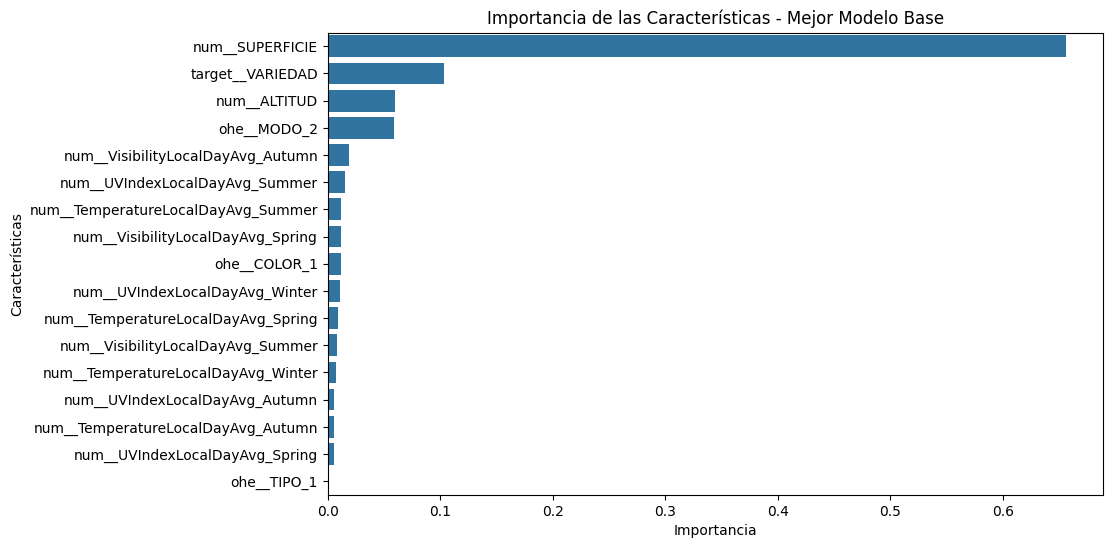

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor del ensemble 1)

estimadores_stacking = [(nombre, modelo) for nombre, modelo in modelos_base.items()]

ensemble1 = StackingRegressor(
    estimators=estimadores_stacking,
    final_estimator=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1),
    cv=kf,
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble1.fit(X_train, y_train)
y_pred = ensemble1.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]

# Check if the model has feature_importances_ attribute
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

### Ensemble 2

In [ ]:
# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X
y_train = y

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    # 'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    # 'RandomForest': RandomForestRegressor(random_state=42),
    # 'LightGBM': LGBMRegressor(random_state=42),
    # 'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(random_state=42),
    # 'ExtraTrees': ExtraTreesRegressor(random_state=42),
    # 'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    # 'XGBoost': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__subsample': uniform(0.5, 0.5),
    #     'model__colsample_bytree': uniform(0.5, 0.5),
    #     'model__gamma': uniform(0, 5),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'RandomForest': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    # },
    # 'LightGBM': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__num_leaves': randint(20, 100),
    #     'model__feature_fraction': uniform(0.5, 0.5),
    #     'model__bagging_fraction': uniform(0.5, 0.5),
    #     'model__min_child_samples': randint(10, 100),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'CatBoost': {
    #     'model__iterations': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__depth': randint(3, 15),
    #     'model__l2_leaf_reg': uniform(1, 10),
    #     'model__random_strength': uniform(0.5, 2),
    #     'model__bagging_temperature': uniform(0, 1),
    #     'model__leaf_estimation_iterations': randint(1, 10)
    # },
    # 'GradientBoosting': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__min_samples_split': randint(2, 20),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__subsample': uniform(0.5, 0.5)
    # },
    # 'ExtraTrees': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    #  },
    'SVR': {
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1),
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': uniform(0.0001, 0.01),
        'model__learning_rate_init': uniform(0.001, 0.1)
    },
    'KNeighbors': {
        'model__n_neighbors': randint(3, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'Ridge': {
        'model__alpha': uniform(0.1, 10)
    },
    'BayesianRidge': {
        'model__max_iter': randint(100, 500)
    }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


Optimizando MLP...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__activation=relu, model__alpha=0.008065429868602328, model__hidden_layer_sizes=(50, 50), model__learning_rate_init=0.07419939418114051; total time=   1.2s
[CV] END model__activation=relu, model__alpha=0.008065429868602328, model__hidden_layer_sizes=(50, 50), model__learning_rate_init=0.07419939418114051; total time=   1.4s
[CV] END model__activation=relu, model__alpha=0.006068501579464871, model__hidden_layer_sizes=(100,), model__learning_rate_init=0.016599452033620267; total time=   1.8s
[CV] END model__activation=relu, model__alpha=0.006068501579464871, model__hidden_layer_sizes=(100,), model__learning_rate_init=0.016599452033620267; total time=   2.1s
[CV] END model__activation=relu, model__alpha=0.008065429868602328, model__hidden_layer_sizes=(50, 50), model__learning_rate_init=0.07419939418114051; total time=   2.6s
[CV] END model__activation=relu, model__alpha=0.008065429868602328, mod

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor del ensemble 2)

estimadores_stacking = [(nombre, modelo) for nombre, modelo in modelos_base.items()]

ensemble2 = StackingRegressor(
    estimators=estimadores_stacking,
    final_estimator=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1),
    cv=kf,
    n_jobs=-1
)

# Entrenamiento y evaluación del ensemble
ensemble2.fit(X_train, y_train)
y_pred = ensemble2.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]

# Comprobar si el modelo tiene el atributo feature_importances_
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


WeightedEnsemble_L2 - RMSE: 0.69, R²: 0.73
El modelo seleccionado no tiene el atributo 'feature_importances_'.


### Ensemble 3


In [ ]:
# Cargar dataset limpio
df = pd.read_csv('df_final_limpio.csv')

columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'PRODUCCION', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']
df = df[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df.drop(columns=[target], errors='ignore')
y = df[target]

X_train = X
y_train = y


# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_features),
    ('ohe', OneHotEncoder(drop='first'), cat_features_ohe),
    ('target', TargetEncoder(), cat_features_target)
])

# Modelos base
modelos_base = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    # 'LightGBM': LGBMRegressor(random_state=42),
    # 'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(random_state=42),
    # 'ExtraTrees': ExtraTreesRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge()
}

# Hiperparámetros para RandomizedSearchCV
param_grid = {
    'XGBoost': {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 15),
        'model__subsample': uniform(0.5, 0.5),
        'model__colsample_bytree': uniform(0.5, 0.5),
        'model__gamma': uniform(0, 5),
        'model__reg_alpha': uniform(0, 2),
        'model__reg_lambda': uniform(0, 2)
    },
    'RandomForest': {
        'model__n_estimators': randint(100, 1000),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 15),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['auto', 'sqrt', 'log2', None]
     },
    # 'LightGBM': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__num_leaves': randint(20, 100),
    #     'model__feature_fraction': uniform(0.5, 0.5),
    #     'model__bagging_fraction': uniform(0.5, 0.5),
    #     'model__min_child_samples': randint(10, 100),
    #     'model__reg_alpha': uniform(0, 2),
    #     'model__reg_lambda': uniform(0, 2)
    # },
    # 'CatBoost': {
    #     'model__iterations': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__depth': randint(3, 15),
    #     'model__l2_leaf_reg': uniform(1, 10),
    #     'model__random_strength': uniform(0.5, 2),
    #     'model__bagging_temperature': uniform(0, 1),
    #     'model__leaf_estimation_iterations': randint(1, 10)
    # },
    # 'GradientBoosting': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__learning_rate': uniform(0.01, 0.2),
    #     'model__max_depth': randint(3, 15),
    #     'model__min_samples_split': randint(2, 20),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__subsample': uniform(0.5, 0.5)
    # },
    # 'ExtraTrees': {
    #     'model__n_estimators': randint(100, 1000),
    #     'model__max_depth': randint(3, 20),
    #     'model__min_samples_split': randint(2, 15),
    #     'model__min_samples_leaf': randint(1, 10),
    #     'model__max_features': ['auto', 'sqrt', 'log2', None]
    #  },
    'SVR': {
        'model__C': uniform(0.1, 10),
        'model__epsilon': uniform(0.01, 1),
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': uniform(0.0001, 0.01),
        'model__learning_rate_init': uniform(0.001, 0.1)
    },
    'KNeighbors': {
        'model__n_neighbors': randint(3, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'Ridge': {
        'model__alpha': uniform(0.1, 10)
    },
    'BayesianRidge': {
        'model__max_iter': randint(100, 500)
    }
}

# Evaluación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_modelos = {}

# Entrenamiento de modelos base con RandomizedSearchCV
for nombre, modelo in modelos_base.items():
    print(f"Optimizando {nombre}...")

    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[nombre],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    mejores_modelos[nombre] = random_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre}: {random_search.best_params_}")


Optimizando XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.4s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.5s
[CV] END model__colsample_bytree=0.6872700594236812, model__gamma=4.75357153204958, model__learning_rate=0.15639878836228102, model__max_depth=7, model__n_estimators=714, model__reg_alpha=0.8916655057071823, model__reg_lambda=0.19994983163600577, model__subsample=0.7296244459829335; total time=   0.4s
[CV] E

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fi

Mejores hiperparámetros para RandomForest: {'model__max_depth': 13, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 774}
Optimizando SVR...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   1.2s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   1.2s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   1.3s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   1.5s
[CV] END model__C=3.845401188473625, model__epsilon=0.9607143064099162, model__kernel=poly; total time=   1.6s
[CV] END model__C=1.6599452033620266, model__epsilon=0.06808361216819946, model__kernel=rbf; total time=   3.7s
[CV] END model__C=1.6599452033620266, model__epsilon=0.068083612

### **Stacking de ensembles**

In [ ]:
print(df_final_limpio.columns.tolist())
# Comprobar si la columna UVIndexLocalDayAvg_Autumn está en df_final
if 'UVIndexLocalDayAvg_Autumn' in df_final.columns:
    print("La columna UVIndexLocalDayAvg_Autumn está en df_final.")
else:
    print("La columna UVIndexLocalDayAvg_Autumn NO está en df_final.")
print(df_final_2021.columns.tolist())
# Comprobar si la columna UVIndexLocalDayAvg_Autumn está en df_final_2021
if 'UVIndexLocalDayAvg_Autumn' in df_final_2021.columns:
    print("La columna UVIndexLocalDayAvg_Autumn está en df_final_2021.")
else:
    print("La columna UVIndexLocalDayAvg_Autumn NO está en df_final_2021.")
columnas_faltantes = [col for col in ['UVIndexLocalDayAvg_Autumn', 'VisibilityLocalDayAvg_Autumn', 'TemperatureLocalDayAvg_Autumn'] if col not in df_final_2021.columns]
if columnas_faltantes:
    print(f"Las siguientes columnas faltan en el DataFrame: {columnas_faltantes}")

['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION']
La columna UVIndexLocalDayAvg_Autumn está en df_final.
['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'DewpointLocalDayAvg_Spring', 'DewpointLocalDayAvg_Summer', 'DewpointLocalDayAvg_Winter', 'FeelsLikeLocalDayAvg_Spring', 'FeelsLikeLocalDayAvg_Summer', 'FeelsLikeLocalDayAvg_Winter', 'PrecipAmountLocalDayAvg_Spring', 'PrecipAmountLocalDayAvg_Summer', 'PrecipAmountLocalDayAvg_Winter', 'RelativeHumidityLocalDayAvg_Spring', 'RelativeHumidityLocalDayAvg_Summer', 'RelativeHumidityLocalDayAvg_Winter', 'SnowAmountLocalDayAvg_Winter', 'TemperatureLocalDayAvg_Spring', 'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter', 'UVIndexLocalDayAvg_Spring', 'UVIndexLocalDayAvg_Summer', 'UVIndexLocalDayAvg_Winter', 'VisibilityLocalDayAvg_Spring', 'VisibilityLocalDayAvg_Summer', 'VisibilityLocalDayAvg_Winter', 'WindSpeedLocalDayAvg_Spring', 'WindSpeedL

In [ ]:
df_final_2021.head()

CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION     ALTITUD  VARIEDAD  MODO  TIPO  \
0       21     48626      302           13  600.000000        32     2     0   
1       21     47921      302           13  600.000000        32     2     0   
2       21     28875      548           14  577.319184        17     2     0   
3       21      5696      919           14  655.000000        59     1     0   
4       21     48093      919           14  655.000000        59     2     0   

   COLOR  SUPERFICIE  ...  TemperatureLocalDayAvg_Winter  \
0      1    1.558208  ...                     281.530508   
1      1    2.125072  ...                     281.530508   
2      1    1.297900  ...                     280.322034   
3      1    2.154085  ...                     280.322034   
4      1    1.241471  ...                     280.322034   

   UVIndexLocalDayAvg_Spring  UVIndexLocalDayAvg_Summer  \
0                   1.573913                   2.413333   
1                   1.573913                   2.413333   
2                   1.564130                   2.416667   
3                   1.564130                   2.416667   
4                   1.564130                   2.416667   

   UVIndexLocalDayAvg_Winter  VisibilityLocalDayAvg_Spring  \
0                   0.501695                  11311.473913   
1                   0.501695                  11311.473913   
2                   0.493220                  11062.597826   
3                   0.493220                  11062.597826   
4                   0.493220                  11062.597826   

   VisibilityLocalDayAvg_Summer  VisibilityLocalDayAvg_Winter  \
0                  12535.223333                  11443.722034   
1                  12535.223333                  11443.722034   
2                  12316.833333                  11211.457627   
3                  12316.833333                  11211.457627   
4                  12316.833333                  11211.457627   

   WindSpeedLocalDayAvg_Spring  WindSpeedLocalDayAvg_Summer  \
0                     3.092391                     2.703333   
1                     3.092391                     2.703333   
2                     3.042391                     2.666667   
3                     3.042391                     2.666667   
4                     3.042391                     2.666667   

   WindSpeedLocalDayAvg_Winter  
0                     4.130508  
1                     4.130508  
2                     4.294915  
3                     4.294915  
4                     4.294915  

[5 rows x 38 columns]

In [ ]:
# Crear el WeightedEnsemble_L2 (Stacking Regressor)

ensemble_final = StackingRegressor(
    estimators=[
        ('ensemble1', ensemble1),
        ('ensemble2', ensemble2),
        ('ensemble3', ensemble3)
    ],
    final_estimator=Ridge(),  # Meta-modelo
    cv=5,  # Validación cruzada
    n_jobs=-1
)



columns_to_keep = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'SUPERFICIE', 'CAMPAÑA', 'TIPO', 'VARIEDAD',
                   'COLOR', 'MODO', 'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                   'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                   'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                   'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']


df_final_2021 = df_final_2021[columns_to_keep]

# Identificar tipos de variables
num_features = ['ALTITUD', 'SUPERFICIE',
                'UVIndexLocalDayAvg_Autumn','UVIndexLocalDayAvg_Spring','UVIndexLocalDayAvg_Summer',
                'UVIndexLocalDayAvg_Winter','VisibilityLocalDayAvg_Autumn','VisibilityLocalDayAvg_Spring',
                'VisibilityLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Autumn','TemperatureLocalDayAvg_Spring',
                'TemperatureLocalDayAvg_Summer', 'TemperatureLocalDayAvg_Winter']

cat_features_ohe = ['MODO', 'TIPO', 'COLOR']
cat_features_target = ['VARIEDAD']
target = 'PRODUCCION'

# Variables predictoras y objetivo
X = df_final_2021


# Entrenamiento y evaluación del ensemble
ensemble_final.fit(X_train, y_train)
y_pred = ensemble_final.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"WeightedEnsemble_L2 - RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Importancia de características del mejor modelo base
mejor_modelo = max(mejores_modelos.items(), key=lambda x: r2_score(y, x[1].predict(X)))[1]
if hasattr(mejor_modelo.named_steps['model'], 'feature_importances_'):
    importancias = pd.Series(
        mejor_modelo.named_steps['model'].feature_importances_,
        index=mejor_modelo.named_steps['preprocessing'].get_feature_names_out()
    ).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importancias, y=importancias.index)
    plt.title("Importancia de las Características - Mejor Modelo Base")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.show()
else:
    print("El modelo seleccionado no tiene el atributo 'feature_importances_'.")

KeyError: "['UVIndexLocalDayAvg_Autumn', 'VisibilityLocalDayAvg_Autumn', 'TemperatureLocalDayAvg_Autumn'] not in index"

## Fichero final

In [ ]:
import joblib

# Guardar el modelo ensemble
joblib.dump(ensemble_final, 'modelo_ensemble_final.pkl')

['modelo_ensemble_final.pkl']

In [ ]:
# Convertir de nuevo a escala original
y_pred = np.expm1(y_pred)


#no tenemos los datos:
#y_real = np.expm1(y_test)

#rmse = np.sqrt(mean_squared_error(y_real, y_pred))
#print(f"WeightedEnsemble_L2 - RMSE en escala original: {rmse:.2f}")

WeightedEnsemble_L2 - RMSE en escala original: 4917.92

In [ ]:
# Cargar el modelo para futuras predicciones:
ensemble_cargado = joblib.load('modelo_ensemble_final.pkl')

# Usar el modelo para hacer predicciones
nuevas_predicciones = ensemble_cargado.predict(X)

In [ ]:
# Obtener las dimensiones del DataFrame df_final_limpio
dimensiones = df_final_limpio.shape
print(f"Dimensiones de df_final_limpio: {dimensiones}")

Dimensiones de df_final_limpio: (7415, 7)


In [ ]:
# Obtener las dimensiones del DataFrame df_final_2021_limpio
dimensiones = df_final_2021_limpio.shape
print(f"Dimensiones de df_final_2021_limpio: {dimensiones}")

Dimensiones de df_final_2021_limpio: (1044, 7)


In [ ]:
# Obtener las dimensiones de nuevas_predicciones
dimensiones_nuevas_predicciones = nuevas_predicciones.shape
print(f"Dimensiones de nuevas_predicciones: {dimensiones_nuevas_predicciones}")

Dimensiones de nuevas_predicciones: (7415,)


In [ ]:
import pandas as pd

# Convertir nuevas_predicciones en un DataFrame
df_nuevas_predicciones = pd.DataFrame(nuevas_predicciones, columns=['PRODUCCION'])

# Mostrar las primeras filas del DataFrame
print(df_nuevas_predicciones.head(10))

# Guardar el DataFrame en un archivo CSV si es necesario
df_nuevas_predicciones.to_csv('nuevas_predicciones.csv', index=False)

   PRODUCCION
0    9.546878
1   10.340784
2    9.558531
3   10.969012
4    9.870721
5   10.255604
6   10.207822
7    9.605177
8   10.350130
9    7.807614


In [ ]:
df_final_limpio.describe()

ID_FINCA     VARIEDAD         MODO         TIPO        COLOR  \
count   7415.000000  7415.000000  7415.000000  7415.000000  7415.000000   
mean   50579.651652    45.319353     1.471477     0.010654     0.853136   
std    28939.164189    23.544996     0.499219     0.102674     0.353995   
min      200.000000     4.000000     1.000000     0.000000     0.000000   
25%    25070.500000    17.000000     1.000000     0.000000     1.000000   
50%    50528.000000    52.000000     1.000000     0.000000     1.000000   
75%    75702.000000    59.000000     2.000000     0.000000     1.000000   
max    99693.000000    94.000000     2.000000     1.000000     1.000000   

        SUPERFICIE   PRODUCCION  
count  7415.000000  7415.000000  
mean      0.998822     8.362410  
std       0.628956     1.326520  
min       0.000720     0.858662  
25%       0.492621     7.562883  
50%       0.887974     8.422003  
75%       1.345863     9.293854  
max       3.106632    12.086844

In [ ]:
import pandas as pd

# Cargar los datasets limpios
#df_final_limpio = pd.read_csv('df_final_limpio.csv')
df_final_2021_limpio = pd.read_csv('df_final_2021_limpio.csv')

# Asegurar que las columnas necesarias están presentes
columnas_requeridas = ['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION']
#df_final_limpio = df_final_limpio[columnas_requeridas]
df_final_2021_limpio = df_final_2021_limpio[columnas_requeridas]

# Añadir las predicciones de nuevas_predicciones a la columna PRODUCCION del año 2021
df_final_2021_limpio['PRODUCCION'] = nuevas_predicciones

# Combinar ambos datasets
#df_combinado = pd.concat([df_final_limpio, df_final_2021_limpio], ignore_index=True)

# Ordenar las columnas según las especificaciones
df_combinado = df_final_2021_limpio.sort_values(by=['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE'])

# Guardar el archivo en el formato requerido
df_combinado.to_csv('VINICHO.txt', sep=';', index=False, header=False, float_format='%.2f')

print("Archivo generado correctamente: VINICHO.txt")

ValueError: Length of values (7415) does not match length of index (1044)

![79439.png](attachment:79439.png)